# Détection d'anomalies avec les auto-encodeurs

*Cas d'usage : lutte contre la fraude*


## Auto-encodeurs

Les auto-encodeurs sont des réseaux de neurones artificiels. Il s'agit d'une méthode non supervisée qui comprend principalement trois parties :
* **Encodeur** : produire une représentation compacte des données d’entrées
* **Espace latent** : vecteurs latents permettant retrouver de l'information à partir de données partielles
* **Décodeur** : reconstruire les données initiales à partir de l’input (ex : des données bruitées)

<img src = "https://jafwin.com/wp-content/uploads/2020/07/Architecture-dun-Auto-encodeur-AE-1.png" title = "google logo" width = "600"  height = "200" >

## Détection d'anomalies

* Les auto-encodeurs peuvent être utilisés pour détecter des anomalies car on suppose que celles-ci seront difficile à prédire par un modèle.

## Détection de la fraude

 1. Apprendre à reconstruire les transactions saines
 2. Reconstruire les transactions de l'ensemble des données test
     * Si l'erreur de reconstruction est importante, la transaction sera considérée comme frauduleuse
     
## Données

Les données sont disponibles [ici.](https://github.com/GuansongPang/anomaly-detection-datasets)



**Note :** Je mets plutôt l'accès sur les auto-encodeurs, je saute volontairement les étapes d'exploration de données et de feature engineering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, precision_recall_curve,
                             auc, roc_curve, classification_report)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

sns.set()
rcParams['figure.figsize'] = 7, 7
random_seed = 123450
class_names = ["Saines", "Fraudes"]

from numpy.random import seed
seed(random_seed)
from tensorflow.random import set_seed
set_seed(random_seed)

In [2]:
path_data = 'data/creditcard.csv'
target = 'Class'
col2drop = [target, 'Time']

dfm = pd.read_csv(path_data)
dfm["Class"] = dfm["Class"].map(lambda x: float(x.replace("'", '')))
dfm['Amount'] = StandardScaler().fit_transform(dfm['Amount'].values.reshape(-1, 1))

dfm.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
Time,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,4.000000,7.000000,7.000000,9.000000
V1,-1.359807,1.191857,-1.358354,-0.966272,-1.158233,-0.425966,1.229658,-0.644269,-0.894286,-0.338262
V2,-0.072781,0.266151,-1.340163,-0.185226,0.877737,0.960523,0.141004,1.417964,0.286157,1.119593
V3,2.536347,0.166480,1.773209,1.792993,1.548718,1.141109,0.045371,1.074380,-0.113192,1.044367
V4,1.378155,0.448154,0.379780,-0.863291,0.403034,-0.168252,1.202613,-0.492199,-0.271526,-0.222187
V5,-0.338321,0.060018,-0.503198,-0.010309,-0.407193,0.420987,0.191881,0.948934,2.669599,0.499361
V6,0.462388,-0.082361,1.800499,1.247203,0.095921,-0.029728,0.272708,0.428118,3.721818,-0.246761
V7,0.239599,-0.078803,0.791461,0.237609,0.592941,0.476201,-0.005159,1.120631,0.370145,0.651583
V8,0.098698,0.085102,0.247676,0.377436,-0.270533,0.260314,0.081213,-3.807864,0.851084,0.069539
V9,0.363787,-0.255425,-1.514654,-1.387024,0.817739,-0.568671,0.464960,0.615375,-0.392048,-0.736727


### Séparation des données en apprentissage / validation / test

In [3]:
train, test = train_test_split(dfm, test_size=0.2, train_size=0.8, stratify=dfm[target], random_state=random_seed)
train, valid = train_test_split(train, test_size=0.2, train_size=0.8, stratify=train[target], random_state=random_seed)
train = train[train[target] == 0]

X_train = train.drop(col2drop, axis=1).to_numpy()
Y_train = train[target]

X_valid = valid.drop(col2drop, axis=1).to_numpy()
Y_valid = valid[target]

X_test = test.drop(col2drop, axis=1).to_numpy()
Y_test = test[target]

In [4]:
nb_epoch = 100
batch_size = 128
_, n_variables = X_train.shape

### Création de l'auto-encodeur

**1. On peut créer les encodeurs et l'encodeur séparément**

**Création de l'encodeur**

In [5]:
input_encoder = layers.Input(shape=(n_variables,))
encoded = layers.Dense(15, activation='tanh')(input_encoder)
encoded = layers.Dense(6, activation='tanh')(encoded)
encoder = keras.models.Model(input_encoder, encoded)

**Création  du décodeur**

In [6]:
input_decoder = layers.Input(shape=(6, ))
decoded = layers.Dense(15, activation='tanh')(input_decoder)
decoded = layers.Dense(n_variables, activation='tanh')(decoded)
decoder = keras.models.Model(input_decoder, decoded)

**Création de l'auto-encodeur**

In [7]:
input_auto = layers.Input(shape=(n_variables,))
encoded = encoder(input_auto)
decoded = decoder(encoded)

autoencoder = keras.models.Model(input_auto, decoded)

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
model (Functional)           (None, 6)                 546       
_________________________________________________________________
model_1 (Functional)         (None, 29)                569       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
_________________________________________________________________


**2. On peut aussi créer l'auto-encodeur avec un `sequential`**

In [8]:
autoencoder = keras.Sequential(
    [
        layers.Input(shape=(n_variables,)),
        
        layers.Dense(15, activation='tanh'),
        
        layers.Dense(6, activation='tanh'),
               
        layers.Dense(15, activation='tanh'),
        
        layers.Dense(n_variables, activation='tanh')
    ]
)


autoencoder.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['accuracy'])

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 15)                450       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 96        
_________________________________________________________________
dense_6 (Dense)              (None, 15)                105       
_________________________________________________________________
dense_7 (Dense)              (None, 29)                464       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
_________________________________________________________________


In [9]:
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

### Fitting du modèle

In [10]:
history = autoencoder.fit(X_train,
                          X_train,
                          epochs=nb_epoch,
                          batch_size=batch_size,
                          shuffle=True,
                          validation_data=(X_valid, X_valid),
                          verbose=1,
                          callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.8330 - accuracy: 0.3443 - val_loss: 0.8217 - val_accuracy: 0.4441
Epoch 2/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.7088 - accuracy: 0.4562 - val_loss: 0.8039 - val_accuracy: 0.4579
Epoch 3/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.6840 - accuracy: 0.4654 - val_loss: 0.7916 - val_accuracy: 0.4518
Epoch 4/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.6565 - accuracy: 0.4573 - val_loss: 0.7763 - val_accuracy: 0.4469
Epoch 5/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.6493 - accuracy: 0.4558 - val_loss: 0.7640 - val_accuracy: 0.4617
Epoch 6/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.6441 - accuracy: 0.4664 - val_loss: 0.7531 - val_accuracy: 0.4602
Epoch 7/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.6403 - accuracy: 0.4692 - val_loss: 0.7432 - val_ac

1422/1422 [==============================] - 1s 1ms/step - loss: 0.5670 - accuracy: 0.4840 - val_loss: 0.6565 - val_accuracy: 0.4788.5743 - accuracy: 0. - ETA: 0s - loss: 0.5728  - ETA: 0s - loss: 0.5680 - accuracy: 0.
Epoch 56/100
1422/1422 [==============================] - 1s 1ms/step - loss: 0.5459 - accuracy: 0.4869 - val_loss: 0.6572 - val_accuracy: 0.4775- 
Epoch 57/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.5541 - accuracy: 0.4873 - val_loss: 0.6563 - val_accuracy: 0.4818: 0s - loss: 0.5586 - accuracy:  - ETA: 0s - loss: 0
Epoch 58/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.5437 - accuracy: 0.4842 - val_loss: 0.6573 - val_accuracy: 0.4800
Epoch 59/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.5486 - accuracy: 0.4864 - val_loss: 0.6564 - val_accuracy: 0.4849
Epoch 60/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.5521 - accuracy: 0.4867 - val_loss: 0.6565 - val_accuracy: 0.48

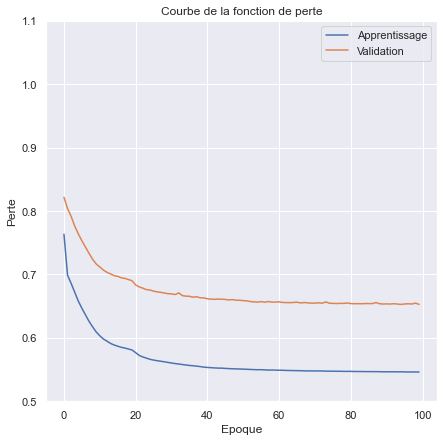

In [11]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Courbe de la fonction de perte')
plt.ylabel('Perte')
plt.xlabel('Epoque')
plt.ylim([0.5, 1.1])
_ = plt.legend(['Apprentissage', 'Validation'], loc='upper right')

**Reconstruction des erreurs sur les données d'apprentissage et calcul du seuil**

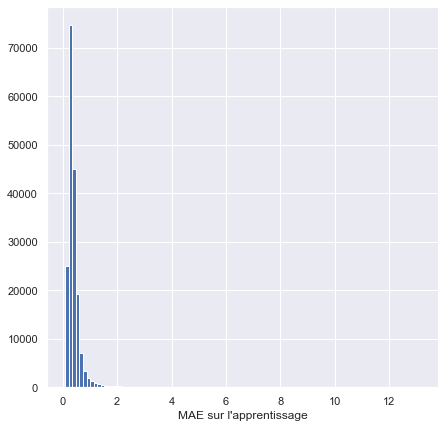

Seuil pour l'erreur de reconstruction : 1.09


In [12]:
# Calcul du MAE sur les données d'apprentissage

X_train_pred = autoencoder.predict(X_train)
mae_train = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(mae_train, bins=100)
plt.xlabel("MAE sur l'apprentissage")
plt.show()

# Calcul du seuil
threshold = np.percentile(mae_train, 97.5)

print("Seuil pour l'erreur de reconstruction : {0:.2f}".format(threshold))

### Evaluation du modèle

#### Echantillon de validation

**Prédiction**

In [13]:
predictions = autoencoder.predict(X_valid)

mse = np.mean(np.power(X_valid - predictions, 2), axis=1)
df_erreurs = pd.DataFrame({'mse': mse,
                           'y_true': Y_valid})
df_erreurs.describe()

,mse,y_true
count,45569.000000,45569.000000
mean,0.652874,0.001734
std,9.620136,0.041601
min,0.016354,0.000000
25%,0.121217,0.000000
50%,0.210191,0.000000
75%,0.405165,0.000000
max,1847.988762,1.000000


**Afficher les erreurs de prédictions sur la classe = 1**

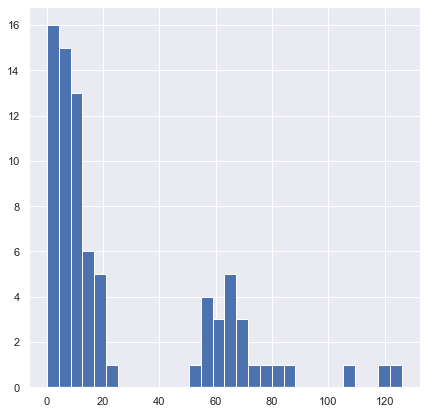

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
df_fraud_erreurs = df_erreurs[df_erreurs['y_true'] == 1]
_ = ax.hist(df_fraud_erreurs.mse.values, bins=30)

**Afficher la courbe ROC**

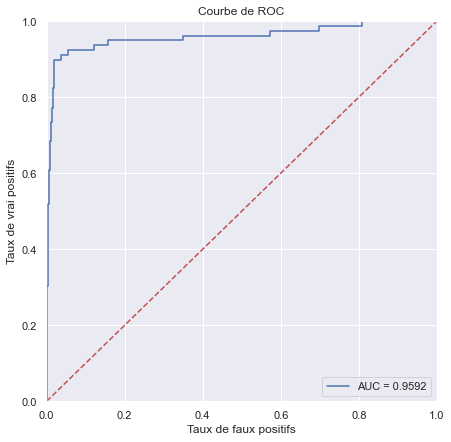

In [15]:
fpr, tpr, thresholds = roc_curve(df_erreurs.y_true, df_erreurs.mse)
roc_auc = auc(fpr, tpr)

plt.title('Courbe de ROC')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('Taux de vrai positifs')
plt.xlabel('Taux de faux positifs')
plt.show();

**Afficher la courbe Précision Recall**

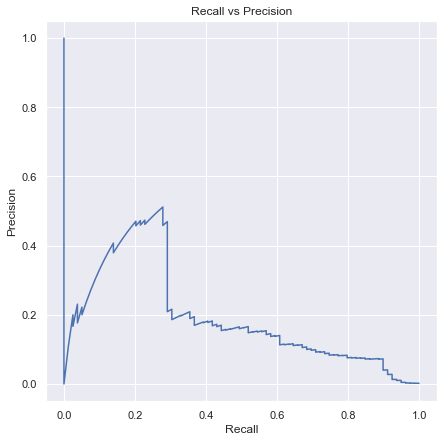

In [16]:
precision, recall, th = precision_recall_curve(df_erreurs.y_true, df_erreurs.mse)
plt.plot(recall, precision, 'b', label='Courbe precision-recall')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

**Afficher les performances du modèle**

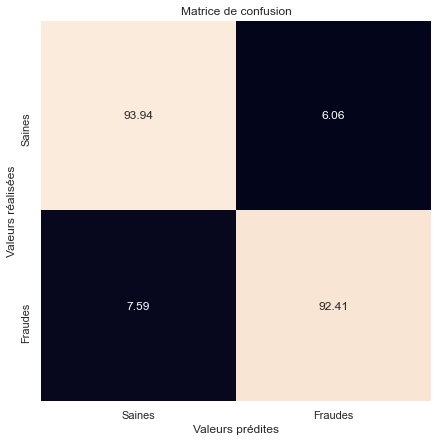

In [17]:
y_pred = [1 if e > threshold else 0 for e in df_erreurs.mse.values]
conf_matrix = confusion_matrix(df_erreurs.y_true, y_pred)
conf_matrix = 100 * conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt=".2f", cbar=False);
plt.title("Matrice de confusion")
plt.ylabel('Valeurs réalisées')
plt.xlabel('Valeurs prédites')
plt.show()

#### Echantillon de test

In [18]:
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
df_erreurs = pd.DataFrame({'mse': mse,
                           'y_true': Y_test})
df_erreurs.describe()

,mse,y_true
count,56962.000000,56962.000000
mean,0.592863,0.001720
std,3.737291,0.041443
min,0.013629,0.000000
25%,0.120684,0.000000
50%,0.205605,0.000000
75%,0.399055,0.000000
max,305.373154,1.000000


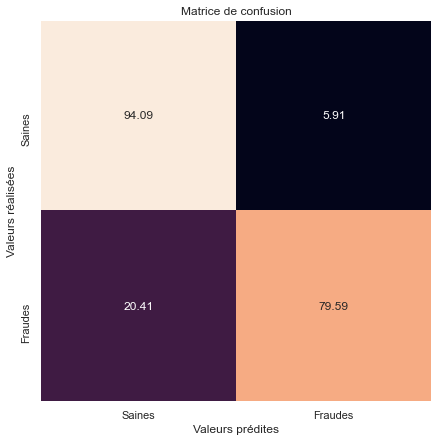

In [19]:
y_pred = [1 if e > threshold else 0 for e in df_erreurs.mse.values]
conf_matrix = confusion_matrix(df_erreurs.y_true, y_pred)
conf_matrix = 100 * conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt=".2f", cbar=False);
plt.title("Matrice de confusion")
plt.ylabel('Valeurs réalisées')
plt.xlabel('Valeurs prédites')
plt.show()

**Sources :**

[Timeseries anomaly detection using an Autoencoder](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)   
[Fraud Detection Using Autoencoders in Keras with a TensorFlow Backend](https://blogs.oracle.com/datascience/fraud-detection-using-autoencoders-in-keras-with-a-tensorflow-backend)    
[Introduction aux auto-encodeurs](https://atcold.github.io/pytorch-Deep-Learning/fr/week07/07-3/)    